# `AA Workshop 05` - Linear Regression

This notebook introduced linear regression modeling in Python.

We will go through the following:
- manual implementation of gradient descent
- linear regression using scikit-learn
- multi-dimensional linear regression
- regression evaluation metrics

---

## Libraries for machine learning in Python

Let's start with some information about the types of libraries we will use to run machine learning algorithms in Python. Although there are a number of machine learning packages available, by far the most popular Python library for general-purpose "classical" machine learning (this is in contrast to packages focused specficially on deep learning, such as [TensorFlow](http://www.tensorflow.org)) is the [scikit-learn](http://scikit-learn.org/) library. Scikit-learn is a general purpose machine learning library with a number of common machine learning algorithms built in.

One important note, however, is that (despite some ongoing efforts to make it more scalable) scikit-learn is still best suited for small to medium-scale problems (say with ~10,000s of examples and ~1,000s of features). For these size problems, most of the algorithms contained in the library will work reasonably fast, and the library has the advantage that one can train many different types of algorithms all with the same interface. However, if you have data that is much bigger than this, then the algorithms start to get fairly slow compared to other more specialized libraries, and you are likely better off using an alternative library.

Another important caveat - and this is one that sadly often gets ignored - is that unlike other software libraries, you _need_ to have some understanding of what the algorithms do in order to use scikit-learn effectively. This is because virtually all algorithms will have a substantial number of hyperparameters (= settings to the algorithm that can drastically affect performance). Sadly, a surprisingly large number of the statements people make about data science techniques seem less about the actual algorithms and more about whatever default settings scikit-learn happens to have for each algorithm. This is why you get people saying things like "support vector machines worked better than neural networks for this problem", which is a completely meaningless statement unless you know _what sort_ of support vector machine, and _what architecture_ neural network. Maybe in some years we will be at a place where the ML algorithms truly are "self-contained", and practitioners don't need to know anything about the underlying algorithms to get good performance (certainly, some researchers and companies are attempting to develop tools that move in this direction). But for the vast majority of tasks, we are still far away from this point, and you _do_ absolutely need to understand the algorithms to get reasonable performance.

---

## Example: Predicting peak electrical power
Suppose you want to predict what the peak electricity demand will be during the day tomorrow for some area (the data is from Pittsburgh). This is actually a very important problem from a logistics planning perspective: electricity generators, which for the most part are based upon boiling water to move turbines, cannot turn on instantly, so in order to guarantee that we have enough power to supply a given area, a system operator typically needs to have some excess generation always waiting in the wings. The better we can forecast future demand, the smaller our excess margin can be, leading to increased efficiency of the entire electrical grid.

The power consumption tomorrow depends on many factors: temperature, day of week, season, holiday events, etc. - not to mention some inherent randomness that we don’t expect to even predict with perfect accuracy.

What _is_ easy, however, is simply to collect lots of data about past energy consumption (the system operator serving the Pittsburgh region, PJM, maintains a data set available [here](https://dataminer2.pjm.com/feed/hrl_load_metered/definition)) as well as the past factors that affect consumption, like the past weather for the area. We combined this into the `Pittsburgh_load_data.csv` dataset (in the `data` folder in the project root directory).


Let's first import relevant libraries.

In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

Then, let's import the dataset. Note that 'AVG', 'MAX', and 'MIN' are in GW, 'Total' in GWh, and 'High_temp' and 'Avg_temp' in degrees Celsius.

In [2]:
df = pd.read_csv("../data/Pittsburgh_load_data.csv")
df.head()

,Date,AVG,MAX,MIN,Total,High_temp,Avg_temp
0,01.01.2013,1.598524,1.859947,0.001599,38.368031,0.0,-1.68
1,02.01.2013,1.809347,2.054215,0.001809,43.428194,-3.9,-6.58
2,03.01.2013,1.832822,2.049550,0.001833,43.991607,0.6,-6.12
3,04.01.2013,1.812699,2.008168,0.001813,43.508609,0.0,-1.95
4,05.01.2013,1.662036,1.838251,0.001662,39.892360,1.7,-1.47


In [3]:
# convert 'Date'-column
df["Date"] = pd.to_datetime(df["Date"],format="%d.%m.%Y")
df = df.sort_values("Date")

In [4]:
# inspect raw data
df.describe()

,Date,AVG,MAX,MIN,Total,High_temp,Avg_temp
count,1825,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,2015-07-02 21:30:04.931506688,1.625500,1.864475,0.001625,39.007871,16.247726,11.322263
min,2013-01-01 00:00:00,1.187175,1.316033,0.001187,28.494714,-15.600000,-40.790000
25%,2014-04-03 00:00:00,1.455030,1.628122,0.001455,34.917959,7.800000,3.260000
50%,2015-07-03 00:00:00,1.586174,1.798936,0.001586,38.071560,18.300000,13.100000
75%,2016-10-01 00:00:00,1.773888,2.048079,0.001774,42.577061,25.600000,20.330000
max,2017-12-31 00:00:00,2.465262,2.951464,0.002465,59.171705,33.900000,27.610000
std,NaN,0.222458,0.312973,0.000222,5.348285,10.898529,10.452796


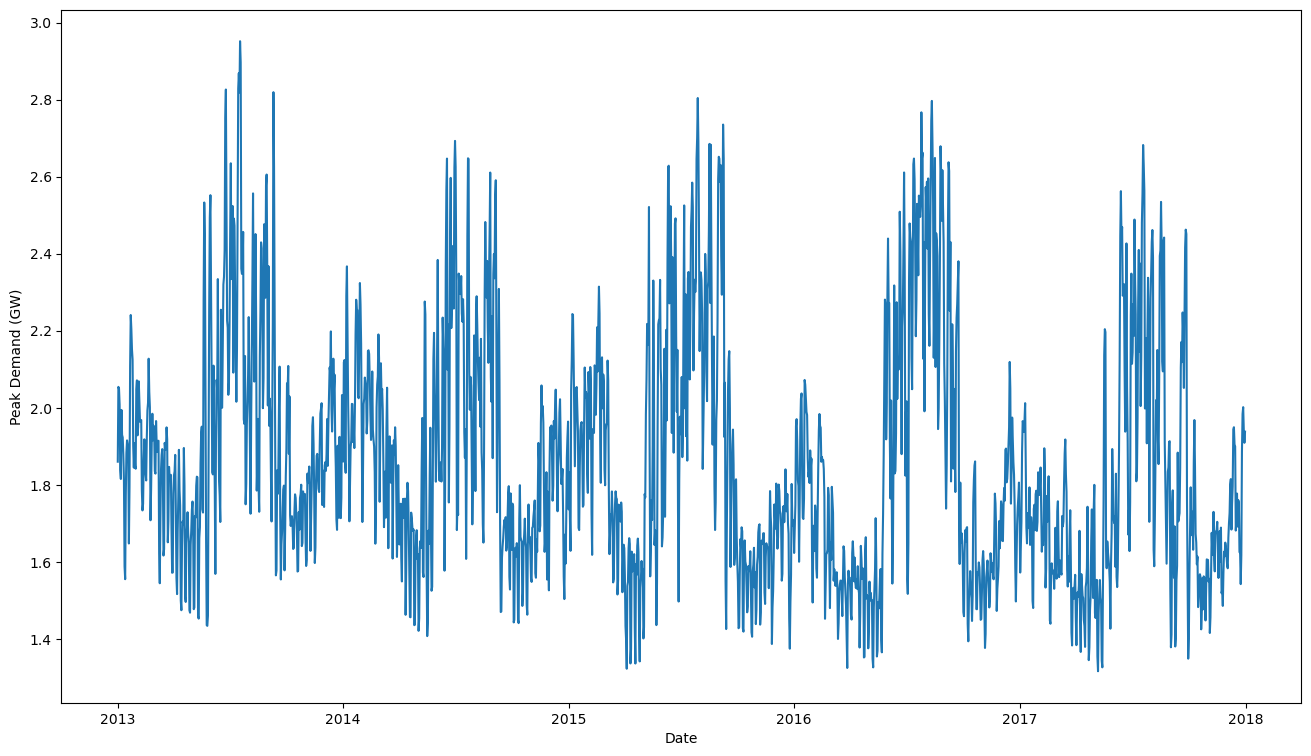

In [5]:
# plot peak demand over time
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(df["Date"],df[["MAX"]])
ax.set_xlabel("Date")
ax.set_ylabel("Peak Demand (GW)")
plt.show()

For the first part of this notebook, we will only consider electricity consumption during the summer months, so let's create a separate dataframe for this:

In [6]:
# create month feature
df["Month"] = df["Date"].apply(lambda dt: dt.month)

# create df_summer
summer_month=[6,7,8]
df_summer = df[df["Month"].isin(summer_month)==True].copy()

df_summer.head()

,Date,AVG,MAX,MIN,Total,High_temp,Avg_temp,Month
151,2013-06-01,1.946586,2.298662,0.001947,46.722317,29.4,24.79,6
152,2013-06-02,1.787233,2.026075,0.001787,42.897404,26.7,23.46,6
153,2013-06-03,1.664323,1.832544,0.001664,39.947248,20.6,17.11,6
154,2013-06-04,1.581505,1.827014,0.001582,37.959541,22.2,15.40,6
155,2013-06-05,1.736095,2.109310,0.001736,41.670127,26.7,19.91,6


For the summer months, there seems to be a strong correlation between temperature and peak electricity demand, as becomes evident when looking at the scatter plot of these two features:

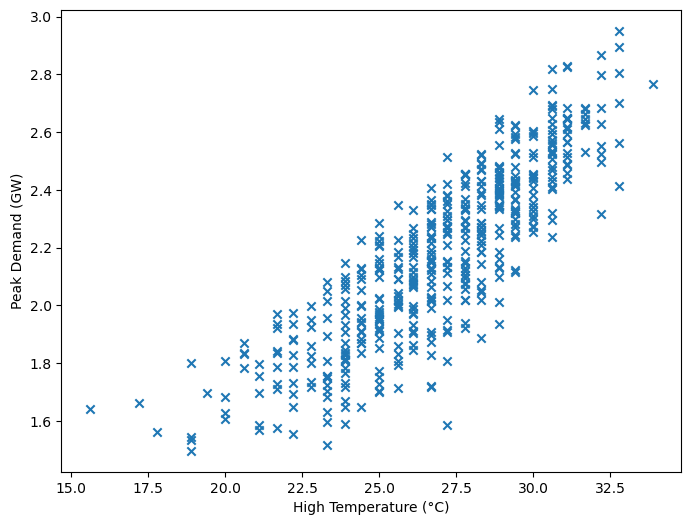

In [7]:
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(df_summer["High_temp"], df_summer["MAX"], marker='x',)
ax.set_xlabel("High Temperature (°C)")
ax.set_ylabel("Peak Demand (GW)")
plt.show()

---

## Linear regression: intuition

As it turns out, electricity consumption in the summer in Pittsburgh is largely
driven by air conditioning, so with increasing high temperature comes increasing
electricity demand.  Thus, we may hypothesize that we can form a fairly good prediction of the peak demand using a linear model: that is, we hypothesize that 
\begin{equation}
\mathrm{PeakDemand} \approx \theta_1 \cdot \mathrm{HighTemperature} + \theta_2
\end{equation}
where $\theta_1$ is the slope of the line and $\theta_2$ is the intercept term (together called the _parameters_ of the model).  

For example, just eyeballing the data we might guess that the slope for peak demand data and average demand data is approximately $\theta_1 = 0.07$ (i.e., we get an increase of 0.07 GW per degree C, which we just arrived at by seeing that the power increased, very approximately, by noticing a total of ~1 GW increase in the range of 14 to 28 degree).  If we further suppose that the average peak demand is about 2.1 GW at 26 degrees C, then we can solve for the intercept term by $0.07*26 + \theta_2 = 2.1$, or $\theta_2 = 0.28$.  Note: if this seems ad-hoc to you, don't worry, it is! We will shortly decribe to actually find good values for these parameters in a disciplined way.

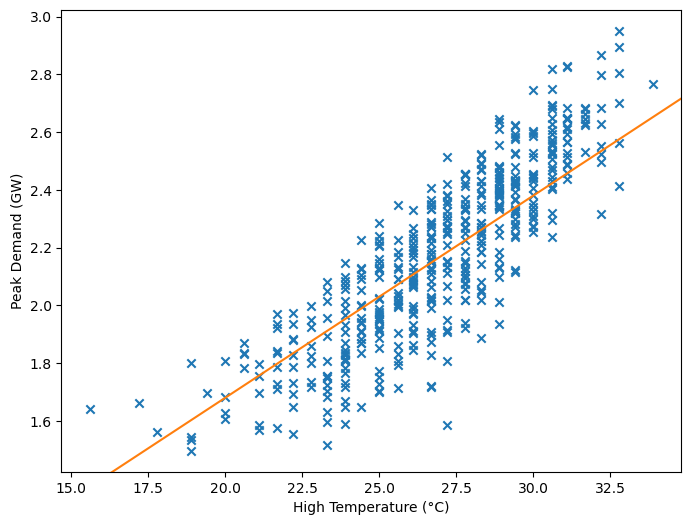

In [8]:
# define x and y
xp = df_summer['High_temp']
yp = df_summer['MAX']

# define theta vector with our estimated values for theta1 and theta2
theta = np.array([0.07, 0.28])

# set up plot
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(xp, yp, marker='x')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())  # gets us the limits of x and y
ax.plot(xlim,[theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'C1')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("High Temperature (°C)")
ax.set_ylabel("Peak Demand (GW)")
plt.show()

Naturally, this model won't fit the data exactly (we can see from the chart that the figure doesn't lie precisely on an exact line), but if we can find slope and intercept terms that fit the data well, then we can simply plug in tomorrow's forecasted high temperature into the equation above and get an estimate of the peak demand tomorrow (ignore the fact, for now, that the high temperature tomorrow is also a prediction - we'll assume we just get this from a reliable source, and domains like weather forecasting are extremely well-studied in practice). This is of course equivalent to just "finding a point on the line".

---

## Manual implementation of gradient descent

### Recap: hypothesis, loss & data scaling

The question, of course, is how to find "the best possible" values for $\theta_1$ and $\theta_2$, so that the line fits the data as "closely" as possible. We will first use the method called _gradient descent_, which is an _extremely_ powerful and general algorithm. However, as you know from the lectures, there is an analytical solution to finding the best model parameters of a linear regression.

**Objective functions**:  In order to find good values for the parameters, we need to formally define what "good" means in this setting.  This will actually be one of the key questions for machine learning algorithms in general, and different notions of "goodness" lead to different algorithms.  Fortunately, there are some very well-studied definitions in this context, and so we have some "standard" options that we can try.  The notion that we will consider here captures the idea of the "squared error" between the prediction and the actual values. That is, we consider all the days in the plot above, where $\mathrm{HighTemperature}^{(i)}$ denotes the high temperature and $\mathrm{PeakDemand}^{(i)}$ denotes the peak demand on day $i$. Since _predicted_ peak demand for day $i$ is equal to
\begin{equation}
\theta_1 \cdot \mathrm{HighTemperature} + \theta_2
\end{equation}
we want to make this quantity as close as possible, averaged over all the days, to the true $\mathrm{PeakDemand}^{(i)}$.  We're going to measure this closeness in terms of the squared difference between the predicted and actual peak demand.  More formally, we would like to minimize the quantity:
\begin{equation}
\frac{1}{\# \mathrm{days}} \sum_{i \in \mathrm{days}} \left ( \theta_1 \cdot \mathrm{HighTemperature}^{(i)} + \theta_2 - \mathrm{PeakDemand}^{(i)} \right )^2 \equiv E(\theta)
\end{equation}
which we abbreviate as $E(\theta)$ to emphasize the fact that we are going to be minimizing this error by tuning our $\theta$ variables.  This is known as the _objective function_ that we are trying to minimize.  A natural question that you may be asking is: why did we choose to measure closeness using this squared difference?  Why not use the average of absolute difference?  Or the maximum absolute difference?  These are good questions, and we'll defer answering them for now, except for saying that we will definitely consider other possibilities later.  The squared error is simply a very common choice, mainly for reasons of mathematical convenience.

**Data scaling**:  We'll shortly see what the gradient descent procedure looks like in our example above.  Before we apply the algorithm, though, we're going to make one small modification to our problem, and _normalize_ the data (both the inputs and the output) before we attempt to run the gradient descent algorithm.  We will see the reason for this more clearly shortly, but the brief reason is that if our slope and intercept terms are on very different "scales" (which would be the case here, because of the relatively large input values (units of degrees Celsius) compared to the output values (units of gigawatts)), then we would actually need to take very different step sizes in the two parameters $\theta_1$ and $\theta_2$.  This is possible to manually tune in our case, but when we start having many more parameters, it's not feasible.  We thus make our life much easier if we scale all the input and output data to be in the same rough range _before_ running gradient descent (Note: in class we talked about only scaling the input, which also happens to work fine here, but I think it may be easier conceptually to consider the case where we just normalize all the inputs and outputs in the same manner).

We can re-scale data in a number of ways, but a simple strategy is just to translate and scale the coordinates such that the values vary between zero and one in our dataset.  This can be easily achieved by the transformation
\begin{equation}
\tilde{x}^{(i)} = \frac{x^{(i)} - \min(x)}{\max(x) - \min(x)}
\end{equation}
and similarly for $\tilde{y}^{(i)}$. 

In [9]:
# normalize xp and yp
xp_nor = (xp-min(xp))/(max(xp)-min(xp))
yp_nor = (yp-min(yp))/(max(yp)-min(yp))

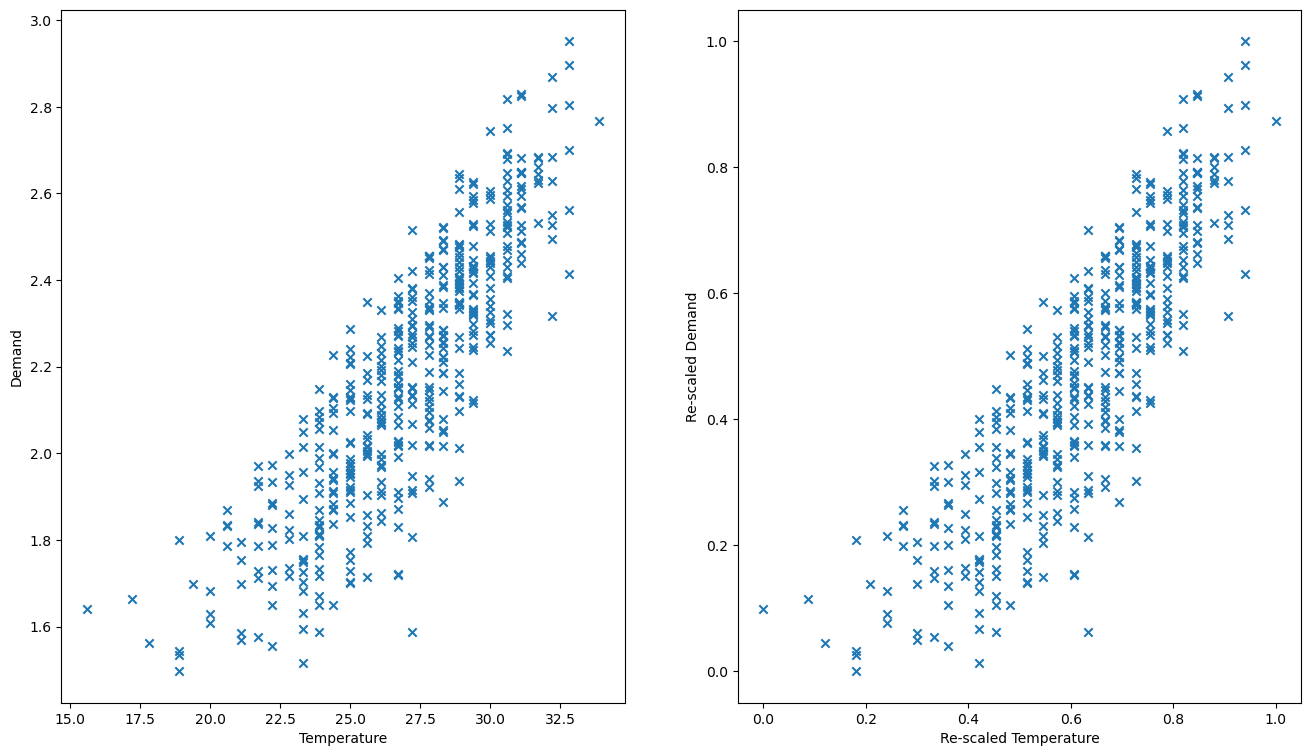

In [10]:
# inspect the difference after re-scaling
fig, axes = plt.subplots(1,2,figsize = (16,9))
axes[0].scatter(xp, yp, marker='x')
axes[0].set_xlabel("Temperature")
axes[0].set_ylabel("Demand")
axes[1].scatter(xp_nor, yp_nor, marker = 'x')
axes[1].set_xlabel("Re-scaled Temperature")
axes[1].set_ylabel("Re-scaled Demand")

plt.show()

The left plot looks identical to the right plot, of course, except that the units no longer correspond to traditional quantities like degrees Celsius or gigawatts, but just some linear transformation of these units.

### Manually implementing gradient descent

Now let's look at the gradient descent algorithm, which we have derived mathematically in the lectures.  This will initialize $\theta_1$ and $\theta_2$ to zero and repeatedly update them according to the partial derivative rules.  We will use the step size (also known as learning rate) $\alpha=0.5$, and print out the value of $\theta$ per each iteration.

\begin{equation}
\theta_j  := \theta_j  − \alpha \sum_{j=1}^m (\sum_{i=1}^n \theta_j x_j^{(i)} - y^{(i)})x_j^{(i)}
\end{equation}

Note: The above simplified equation omits the number of days (n) and the *2 term which results from partial differentiation and groups them into the alpha term for easier representation.

In [11]:
# manual implementation of gradient descent
def gradient_descent(iters, alpha):
    theta = np.array([0., 0.])
    for t in range(iters):
        theta_old = theta.copy()
        theta[0] -= alpha/len(xp) * 2 * sum((theta_old[0] * xp_nor + theta_old[1] - yp_nor)*xp_nor)
        theta[1] -= alpha/len(xp) * 2 * sum((theta_old[0] * xp_nor + theta_old[1] - yp_nor))
    return theta

def plot_fit(theta):
    
    Error = sum((theta[0]*xp_nor + theta[1] - yp_nor)**2)
    
    # compute partial derivative (i.e. gradient) for theta 1 and 2
    def_theta1 = sum((theta[0] * xp_nor + theta[1] - yp_nor)*xp_nor)
    def_theta2 = sum((theta[0] * xp_nor + theta[1] - yp_nor))
    
    # plot
    plt.figure(figsize = (8,6))
    plt.scatter(xp_nor, yp_nor, marker = 'x')
    plt.xlabel("Nomalized Temperature")
    plt.ylabel("Normalized Demand")
    xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
    plt.plot(xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'C1')
    plt.xlim(xlim)
    plt.ylim(ylim)
    print('Theta = ', theta, 'Error = ',Error,'def_theta1 = ',def_theta1, 'def_theta2 = ', def_theta2)

Theta =  [0. 0.] Error =  120.45367103680132 def_theta1 =  -146.79528000013352 def_theta2 =  -214.99380359038364


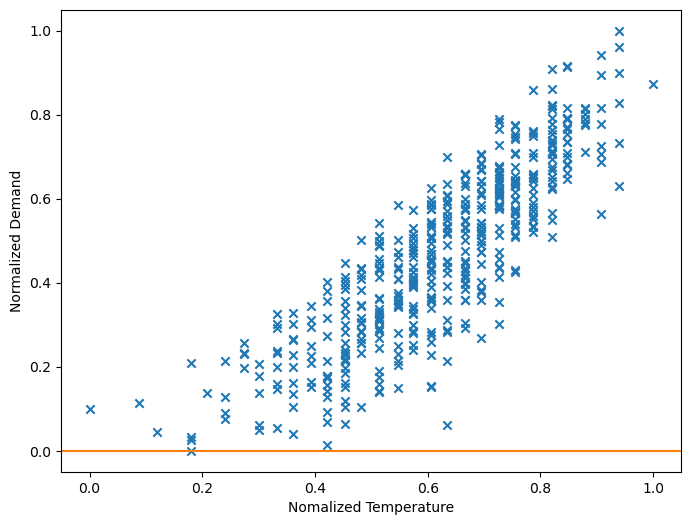

In [12]:
# initialization
plot_fit(gradient_descent(0, alpha=0.5))

Theta =  [0.31981542 0.46839609] Error =  30.334531187078966 def_theta1 =  46.759735338362624 def_theta2 =  90.89748566457052


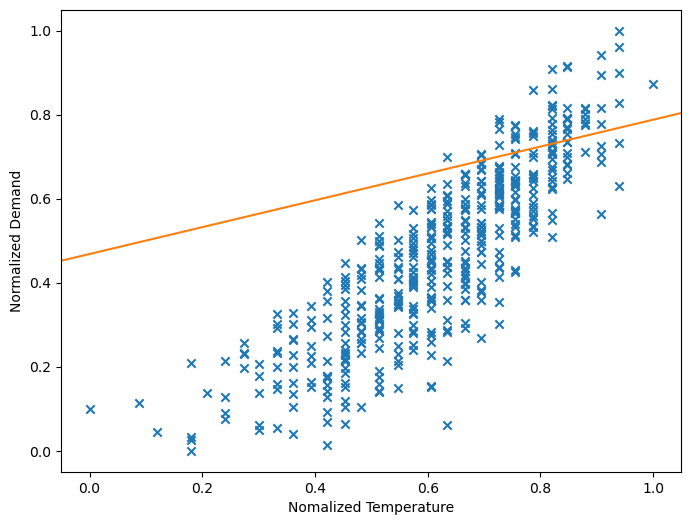

In [13]:
# five iterations
plot_fit(gradient_descent(1, alpha=0.5))

Theta =  [0.21794236 0.27036235] Error =  16.23538524474279 def_theta1 =  -28.77373532865188 def_theta2 =  -28.954216869875314


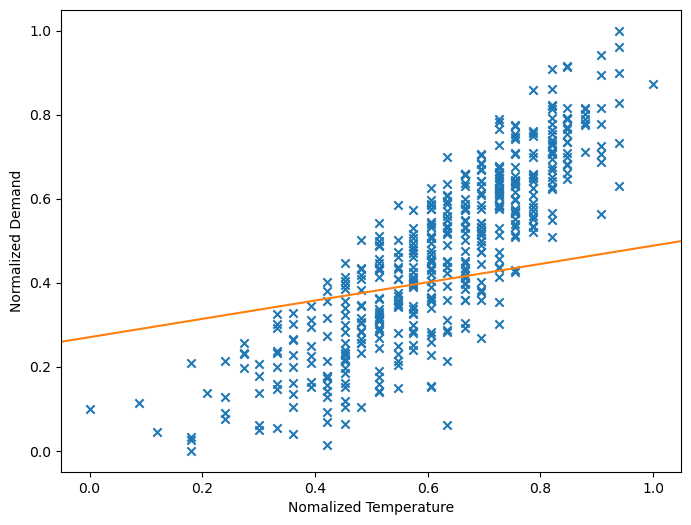

In [14]:
# five iterations
plot_fit(gradient_descent(2, alpha=0.5))

Theta =  [0.28063024 0.33344343] Error =  13.791749911481235 def_theta1 =  0.9997626256994625 def_theta2 =  17.8170592034697


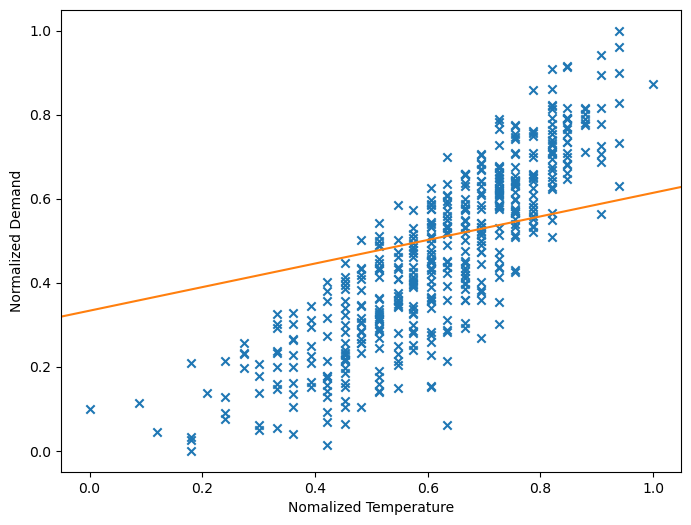

In [15]:
# five iterations
plot_fit(gradient_descent(3, alpha=0.5))

Theta =  [0.27845211 0.29462631] Error =  13.144744816748256 def_theta1 =  -10.444336153404738 def_theta2 =  -0.6190656057702194


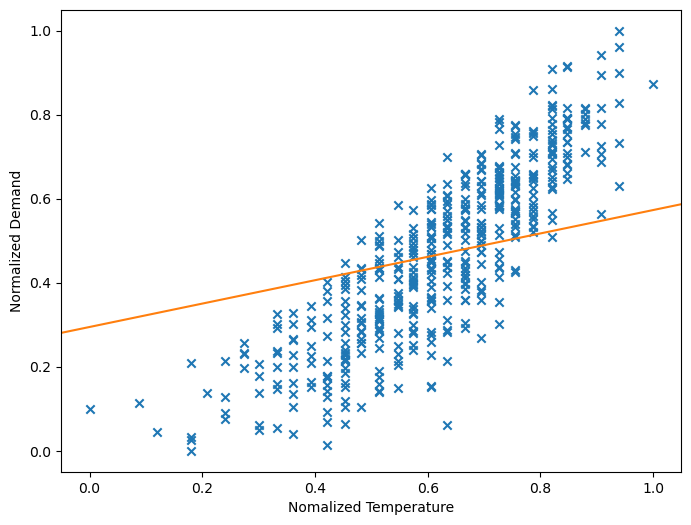

In [16]:
# five iterations
plot_fit(gradient_descent(4, alpha=0.5))

Theta =  [0.30120665 0.29597504] Error =  12.783873705470329 def_theta1 =  -5.761601337566325 def_theta2 =  6.467264450050435


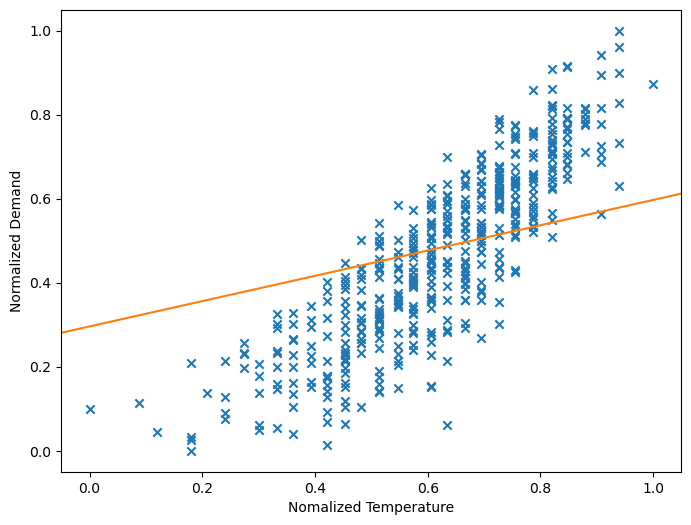

In [17]:
# five iterations
plot_fit(gradient_descent(5, alpha=0.5))

Theta =  [ 0.94718692 -0.11673103] Error =  5.48215500126932 def_theta1 =  -1.0043384354287503 def_theta2 =  0.6347759196790904


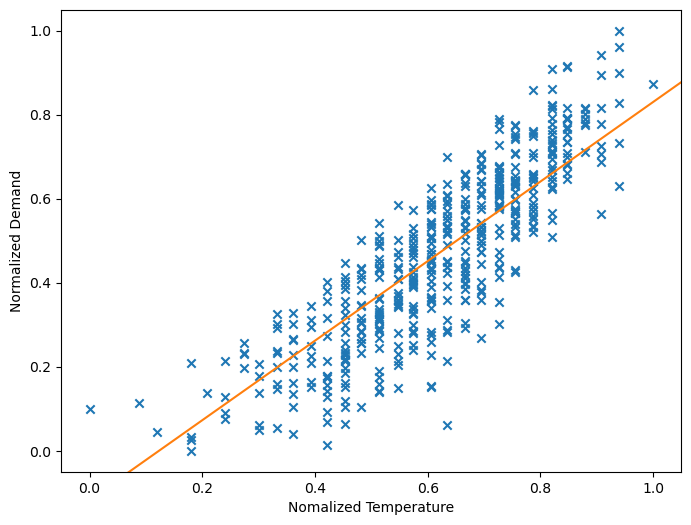

In [18]:
plot_fit(gradient_descent(100, alpha=0.5))

Theta =  [ 1.05505079 -0.18490465] Error =  5.330548192293141 def_theta1 =  -9.802948501558273e-09 def_theta2 =  6.195790963614556e-09


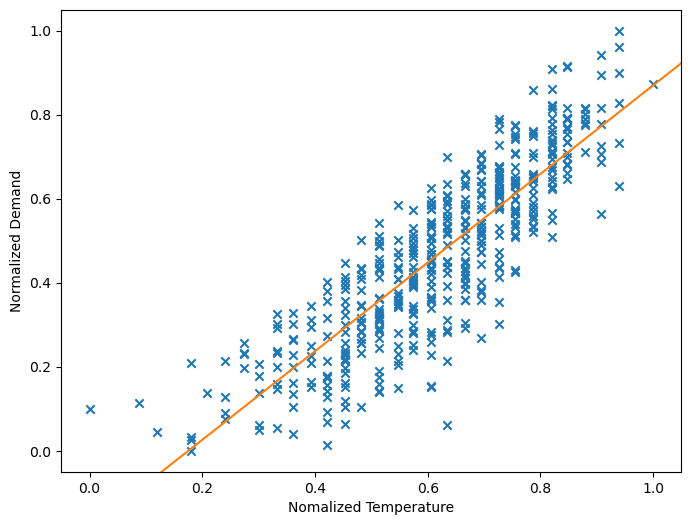

In [19]:
# five iterations
plot_fit(gradient_descent(1000, alpha=0.5))

### Error vs. iteration

Let's look at the average error versus iteration.

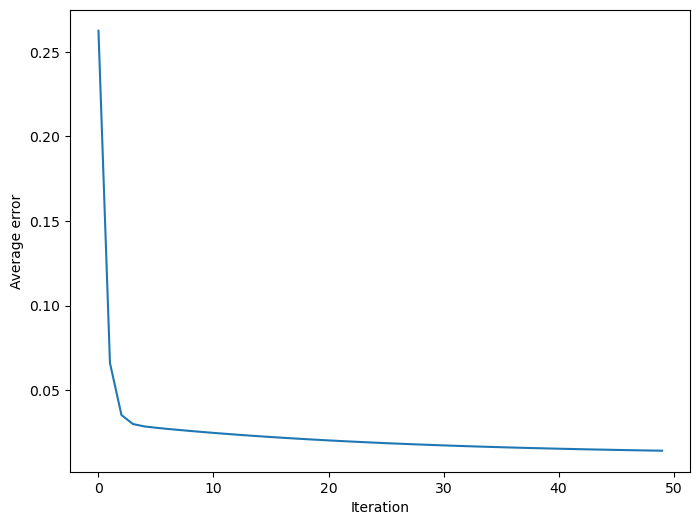

In [20]:
def gradient_descent_err(iters):
    err = []
    theta = np.array([0., 0.])
    alpha = 0.5
    for t in range(iters):
        theta_old = theta.copy()
        err.append(np.mean((theta_old[0] * xp_nor + theta_old[1] - yp_nor)**2))
        theta[0] -= alpha/len(xp) * 2 * sum((theta_old[0] * xp_nor + theta_old[1] - yp_nor)*xp_nor)
        theta[1] -= alpha/len(xp) * 2 * sum((theta_old[0] * xp_nor + theta_old[1] - yp_nor) )
    return np.array(err)
plt.figure(figsize = (8,6))
plt.plot(np.arange(0,50), gradient_descent_err(50))
plt.xlabel("Iteration")
plt.ylabel("Average error")
plt.show()

### Effect of the step size (learning rate)

When using gradient descent, one of the hyperparameters we need to set is the step size (or learning rate) denoted by $\alpha$ in the gradient descent updating formula.

To understand the effect of different choices for $\alpha$, let us visualize the gradient descent iterations from our example above in a different way:

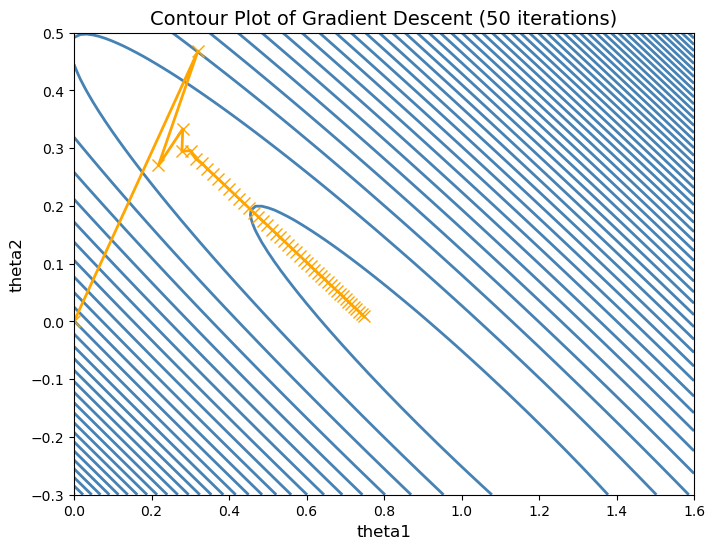

In [21]:
# create contours of loss function using grid of theta1 and theta2 values and generating the corresponding error for all combinations
theta1_vals = np.linspace(0, 1.6, 100)
theta2_vals = np.linspace(-0.3, 0.5, 100)
se_vals = np.zeros(shape=(theta1_vals.size, theta2_vals.size)) # placeholder to be populated with errors below
for i, val_2 in enumerate(theta2_vals):
    for j, val_1 in enumerate(theta1_vals):
        se_vals[i, j] = sum((val_1*xp_nor + val_2 - yp_nor)**2)

# save theta1 and theta2 values of first 50 gradient descent iterations
gd_theta1s = []
gd_theta2s = []
for i in range(50):
    gd_theta1s.append(gradient_descent(i, alpha=0.5)[0])
    gd_theta2s.append(gradient_descent(i, alpha=0.5)[1])

# plot
fig, ax = plt.subplots(figsize=(8,6))
CS = plt.contour(theta1_vals, theta2_vals, se_vals, levels=np.arange(0,510, 10), linewidths=2, colors="steelblue")
#plt.clabel(CS, inline=1, fontsize=8)
plt.plot(gd_theta1s, gd_theta2s, color="orange", linewidth=2, marker="x", markersize=8)
plt.title("Contour Plot of Gradient Descent (50 iterations)", fontsize=14)
plt.xlabel("theta1", fontsize=12)
plt.ylabel("theta2", fontsize=12)
plt.show()

Now, let's illustrate what happens if we set $\alpha$ to, for example, 0.6.

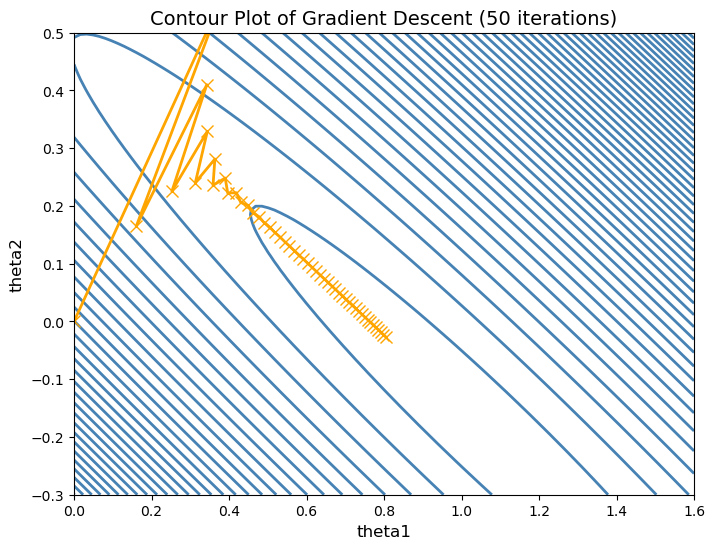

In [22]:
# save theta1 and theta2 values of first 50 gradient descent iterations
gd_theta1s = []
gd_theta2s = []
for i in range(50):
    gd_theta1s.append(gradient_descent(i, alpha=0.6)[0])
    gd_theta2s.append(gradient_descent(i, alpha=0.6)[1])

# plot
fig, ax = plt.subplots(figsize=(8,6))
CS = plt.contour(theta1_vals, theta2_vals, se_vals, levels=np.arange(0,510, 10), linewidths=2, colors="steelblue")
#plt.clabel(CS, inline=1, fontsize=8)
plt.plot(gd_theta1s, gd_theta2s, color="orange", linewidth=2, marker="x", markersize=8)
plt.title("Contour Plot of Gradient Descent (50 iterations)", fontsize=14)
plt.xlabel("theta1", fontsize=12)
plt.ylabel("theta2", fontsize=12)
plt.xlim([0, 1.6])
plt.ylim([-0.3, 0.5])
plt.show()

It appears as if this was a smart move. We now arrived at a lower loss after 50 iterations compared to $\alpha = 0.5$, so let's increase our learning rate further.

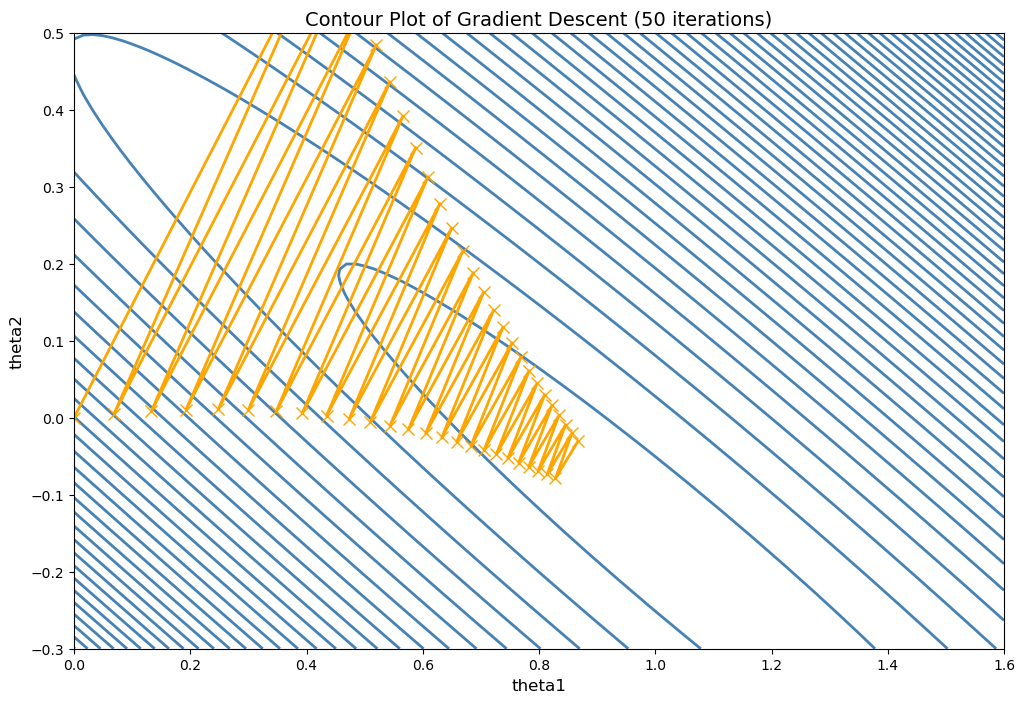

In [23]:
# save theta1 and theta2 values of first 50 gradient descent iterations
gd_theta1s = []
gd_theta2s = []
for i in range(50):
    gd_theta1s.append(gradient_descent(i, alpha=0.7)[0])
    gd_theta2s.append(gradient_descent(i, alpha=0.7)[1])

# plot
fig, ax = plt.subplots(figsize=(12,8))
CS = plt.contour(theta1_vals, theta2_vals, se_vals, levels=np.arange(0,510, 10), linewidths=2, colors="steelblue")
#plt.clabel(CS, inline=1, fontsize=8)
plt.plot(gd_theta1s, gd_theta2s, color="orange", linewidth=2, marker="x", markersize=8)
plt.title("Contour Plot of Gradient Descent (50 iterations)", fontsize=14)
plt.xlabel("theta1", fontsize=12)
plt.ylabel("theta2", fontsize=12)
plt.xlim([0, 1.6])
plt.ylim([-0.3, 0.5])
plt.show()

This plot looks interesting. It appears as if we are still converging, but not necessarily faster compared to $\alpha = 0.5$ or $\alpha = 0.6$. What happens if we still increase the step size?

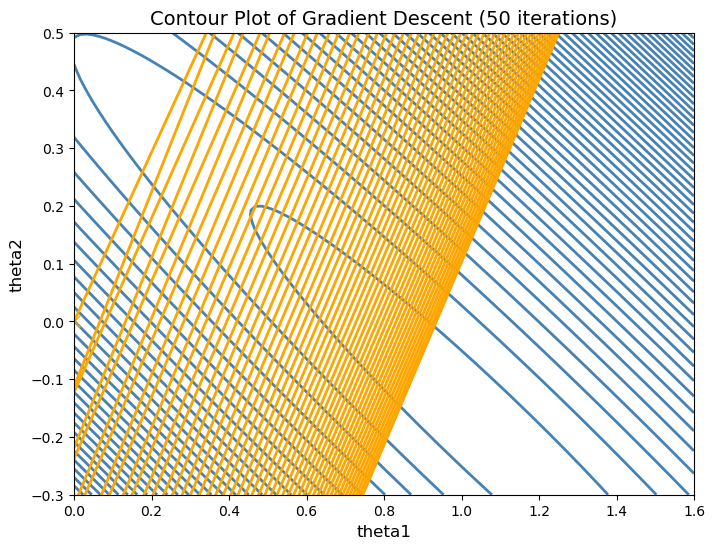

In [24]:
# save theta1 and theta2 values of first 50 gradient descent iterations
gd_theta1s = []
gd_theta2s = []
for i in range(50):
    gd_theta1s.append(gradient_descent(i, alpha=0.8)[0])
    gd_theta2s.append(gradient_descent(i, alpha=0.8)[1])

# plot
fig, ax = plt.subplots(figsize=(8,6))
CS = plt.contour(theta1_vals, theta2_vals, se_vals, levels=np.arange(0,510, 10), linewidths=2, colors="steelblue")
#plt.clabel(CS, inline=1, fontsize=8)
plt.plot(gd_theta1s, gd_theta2s, color="orange", linewidth=2, marker="x", markersize=8)
plt.title("Contour Plot of Gradient Descent (50 iterations)", fontsize=14)
plt.xlabel("theta1", fontsize=12)
plt.ylabel("theta2", fontsize=12)
plt.xlim([0, 1.6])
plt.ylim([-0.3, 0.5])
plt.show()

At $\alpha = 0.8$, it looks like we are diverging - we are "overshooting the target" and actually moving further away from the lowest error with each iteration. As you can see, choosing an appropriate learning rate is crucial to balance the tradeoff between converging very slowly and not converging at all.

### Getting the solution back to the original scales

Remember that we normalized our data before running gradient descent. Therefore, we still need to get our parameters back to the original scales. Fortunately, there is an easy way to do this, given by the following proof:
\begin{equation}
\begin{split}
\tilde{y} & \approx \tilde{x} \cdot \theta_1 + \theta_2\\
\Longrightarrow \;\; \frac{y-a}{b} & \approx \frac{x-c}{d} \cdot \theta_1 + \theta_2 \\
\Longrightarrow \;\; y-a & \approx ((x-c)\cdot \theta_1)/d)\cdot b + b \theta_2 \\
\Longrightarrow \;\; y & \approx x \cdot (b \theta_1/d) + b \theta_2 + a - c b \theta_1/d\\
\Longrightarrow \;\; y & \approx x \cdot \hat{\theta}_1 + \hat{\theta}_2\\
\end{split}
\end{equation}
where
\begin{equation}
a = \min_i y^{(i)}, \;\; b = \max_i y^{(i)} - \min_i y^{(i)}, \;\; c = \min_i x^{(i)}, \;\; d = \max_i x^{(i)} - \min_i x^{(i)}, 
\end{equation}
and where we define
\begin{equation}
\begin{split}
\hat{\theta}_1 & = b \theta_1/d \\
\hat{\theta}_2 & = b \theta_2 + a - c \cdot(b \theta_1/d).
\end{split}
\end{equation}

This might seem like a lot, but all it's saying is that there is an easy formula to convert between the solution we get for the normalized data and the unnormalized data.

In [25]:
# get theta 1 and theta 2 from gradient descent
theta = gradient_descent(1000, alpha=0.5)

# print thetas on normalized scale
print(theta)

[ 1.05505079 -0.18490465]


Using the above expression, let's re-scale the theta parameters to the original scale by creating a new array entitled `theta_hat`.

In [26]:
# define a, b, c, d
a = min(yp)
b = max(yp)-min(yp)
c = min(xp)
d = max(xp) - min(xp)

# use formula from above to re-scale
theta_1 = b*theta[0]/d
theta_2 = b*theta[1] + a - c*(b*theta[0]/d)

#combine into single array
theta_hat = np.array([theta_1,theta_2])

theta_hat

array([ 0.08385936, -0.0802474 ])

Finally we plot the derived linear regression line:

[ 1.05505079 -0.18490465] [ 0.08385936 -0.0802474 ]


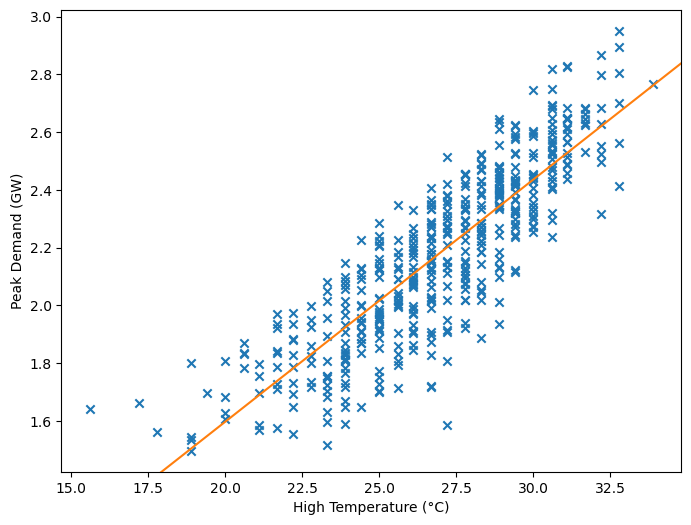

In [27]:
fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(xp, yp, marker='x')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
ax.plot(xlim, [theta_hat[0]*xlim[0]+theta_hat[1], theta_hat[0]*xlim[1]+theta_hat[1]], 'C1')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("High Temperature (°C)")
ax.set_ylabel("Peak Demand (GW)")
print(theta, theta_hat)

---

## Implementation using scikit-learn

Let's look at how we specify a model, fit it to data, and make predictions in scikit-learn. These three tasks form the common usage pattern for most interactions with scikit-learn. Let's first prepare our data. Note that scikit-learn by default will fit a separate intercept term for linear regression models, so we don't include the all-ones entry in our features.

In general, scikit-learn has a different class for each different type of learning algorithm. In this case, we are importing the LinearRegression class. When we initialize the class, we pass various parameters to the constructor. In this case, we are specifying that we will fit an intercept term (i.e., we will not pass it as an explicit feature).

In [28]:
# initialize model
linear_model = LinearRegression(fit_intercept=True)

print(linear_model)

LinearRegression()


Note that when we create this class we haven't actually passed any data to the system.  This is the standard interface for scikit-learn classes: the constructor just initializes the hyperparameters of the model, and when we actually want to fit it to data, we call the `model.fit()` function.

In [29]:
# train model
linear_model.fit(xp.values.reshape((-1,1)), yp) # if we pass a 1-feature array we need to re-shape it! This is not required for multi-dimensional arrays
print(linear_model.coef_, linear_model.intercept_)

[0.08385936] -0.08024740699314936


In [30]:
# compare to own implementation (at 1000 iteration of gradient descent)
theta_hat

array([ 0.08385936, -0.0802474 ])

Finally, when we want to make a prediction on a new data point, we call the model.predict() function, passing in the feature values for the new points we want to predict.

In [31]:
# predict on new data
Xnew = np.array([[25], [23]]) # predict peak load at 25 deg c

print(linear_model.predict(Xnew))

[2.01623653 1.84851782]


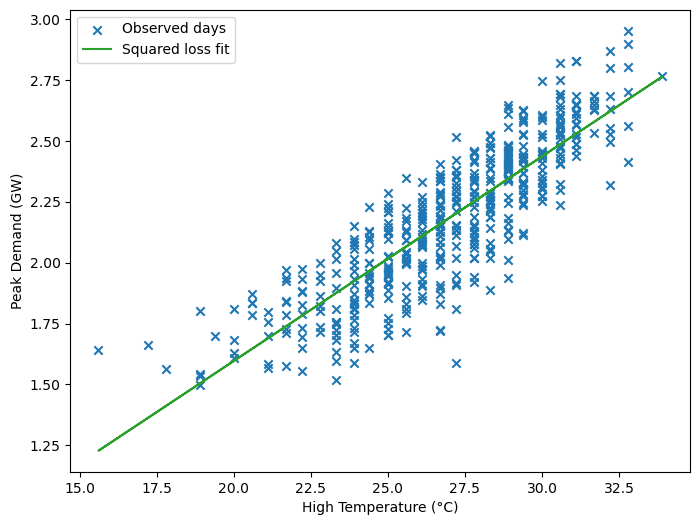

In [32]:
# generate predictions for original data
model_pred = linear_model.predict(xp.values.reshape(-1,1))

# plot regression line of our scikit-learn model
fig,ax = plt.subplots(figsize = (8,6))
ax.scatter(xp, yp, marker="x", label='Observed days')
ax.set_xlabel("High Temperature (°C)")
ax.set_ylabel("Peak Demand (GW)")
ax.plot(xp, model_pred, c='C2', label='Squared loss fit')
ax.legend()
plt.show()

---

## Multi-dimensional linear regression

How do we now incorporate multiple features into our model? Essentially, all we need to do is to pass a larger feature vector to our model.

To illustrate, let us consider differences between weekdays and weekends.

In [33]:
# add a weekday column to our data frame
df_summer["Weekday"] = df_summer["Date"].dt.weekday

# create IsWeekday feature
df_summer["IsWeekday"] = (df_summer["Weekday"] <= 4).astype(int)

# inspect dataframe
df_summer.head(10)

,Date,AVG,MAX,MIN,Total,High_temp,Avg_temp,Month,Weekday,IsWeekday
151,2013-06-01,1.946586,2.298662,0.001947,46.722317,29.4,24.79,6,5,0
152,2013-06-02,1.787233,2.026075,0.001787,42.897404,26.7,23.46,6,6,0
153,2013-06-03,1.664323,1.832544,0.001664,39.947248,20.6,17.11,6,0,1
154,2013-06-04,1.581505,1.827014,0.001582,37.959541,22.2,15.40,6,1,1
155,2013-06-05,1.736095,2.109310,0.001736,41.670127,26.7,19.91,6,2,1
156,2013-06-06,1.734597,1.923417,0.001735,41.633988,21.7,19.28,6,3,1
157,2013-06-07,1.595062,1.799999,0.001595,38.284876,18.9,16.73,6,4,1
158,2013-06-08,1.415416,1.568676,0.001415,33.972964,21.1,16.87,6,5,0
159,2013-06-09,1.549465,1.915678,0.001549,37.190627,27.2,20.94,6,6,0
160,2013-06-10,1.812117,2.072227,0.001812,43.494687,23.9,21.28,6,0,1


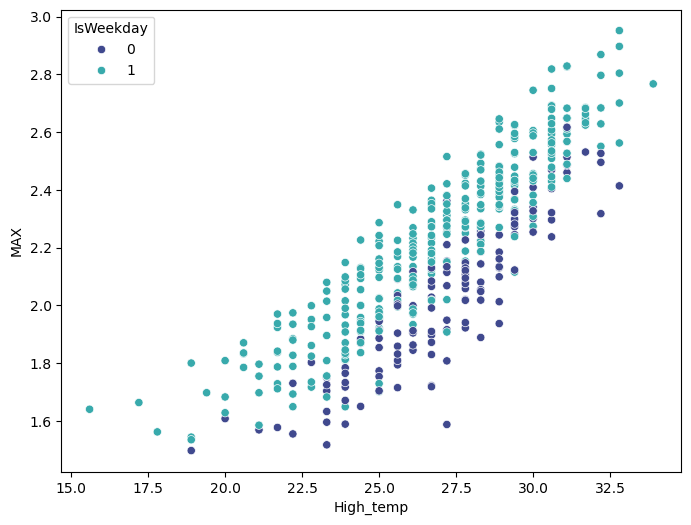

In [34]:
plt.figure(figsize = (8,6))
sns.scatterplot(x=df_summer["High_temp"], y=df_summer["MAX"], marker='o', hue=df_summer["IsWeekday"], palette="mako")
plt.show()

Let us now train a new linear model with an additional feature for weekdays. As mentioned, all we need to do is to pass a larger feature vector to our linear model.

In [35]:
X = df_summer[["High_temp", "IsWeekday"]]
y = df_summer[["MAX"]]
lin_mod_day = LinearRegression()
lin_mod_day.fit(X,y)
y_pred = lin_mod_day.predict(X)

print(lin_mod_day.coef_, lin_mod_day.intercept_)

[[0.08541718 0.22431882]] [-0.28201097]


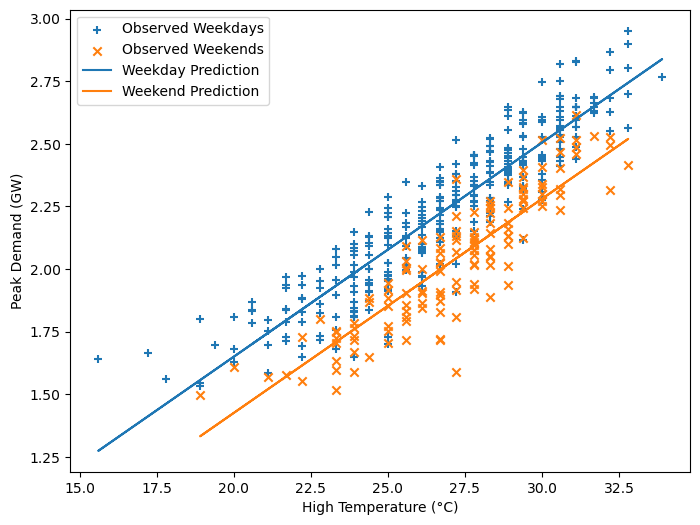

In [36]:
# create two feature vectors for weekdays and weekends
X_weekday = X[X["IsWeekday"]==1]
X_weekend = X[X["IsWeekday"]==0]

# predict weekdays and weekends separately (using the same model!)
y_pred_weekday = lin_mod_day.predict(X_weekday)
y_pred_weekend = lin_mod_day.predict(X_weekend)

plt.figure(figsize = (8,6))

plt.scatter(X_weekday["High_temp"], 
            df_summer[df_summer["IsWeekday"]==1]["MAX"], 
            marker="+", label="Observed Weekdays")

plt.scatter(X_weekend["High_temp"], 
            df_summer[df_summer["IsWeekday"]==0]["MAX"], 
            marker="x", label="Observed Weekends")

plt.plot(X_weekday["High_temp"], 
         y_pred_weekday, 
         label="Weekday Prediction")

plt.plot(X_weekend["High_temp"], 
         y_pred_weekend, 
         label="Weekend Prediction")

plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")

plt.legend()
plt.show()

---

## Model evaluation metrics

We can easily quantify the distance between our predictions and the observed values using several evaluation metrics (see lecture slides). We will shortly summarize three commonly used metrics and show you how you can generate them. **However, keep in mind that we have not split our data into train/holdout/test sets, so the following metrics represent the training loss only. They do not say anything about predictive performance! We will implement a proper cross-validation procedure in the next workshop.**

Let's use the true values and predictions of our multi-dimensional model.

### (Root) Mean Squared Error ((R)MSE)
The MSE calculates the mean of the squared residuals. As the fitting of the linear regression model is (typically) carried out by minimizing the squared error (see loss function in lecture slides), the MSE corresponds directly to the model optimization. The unit of the MSE is the target unit squared, i.e. in the above example using energy consumption in GW, the unit of the MSE is $(GW)^2$. As the residuals (the difference of prediction and observed values) are squared, large deviations are penalized stronger than small deviations. Therefore, the weight of outliers increases using MSE as a metric. This is useful in applications where small prediction errors are not important but large errors have to be avoided.

As the squared unit is hard to interpret, the RMSE can be used instead of the MSE. The RMSE is just the square root of the MSE, meaning that it is monotonic with respect to the MSE - a bigger MSE leads to a bigger RMSE and vice versa.

In [37]:
print("Mean Squared Error:",mean_squared_error(df_summer["MAX"], y_pred),"(GW)^2")
print("Root Mean Squared Error:",mean_squared_error(df_summer["MAX"], y_pred)**0.5,"GW")

Mean Squared Error: 0.014284382607725596 (GW)^2
Root Mean Squared Error: 0.1195172899949024 GW


### Mean Absolute Error (MAE)
Just as the RMSE, the MAE is easy to interpret. It is just the mean absolute value of the error term. When there are no or little major outliers, RMSE and MAE often have the same order of magnitude, with the MAE always being smaller than the RMSE. While a linear regression is typically fitted using the least squares method, the MAE can still be a valuable metric. It is applicable when large errors are not disproportionately worse than smaller errors. For example, when prediciting monetary values, an error of 100 USD might always be twice as bad as an error of 50 USD and so on. If this is the case, the MAE can actually be the more suitable error metric. Like the RSME, the MAE only makes sense when knowing the order of magnitude of the predicted values. On its own, it does not imply good or bad model fit.

In [40]:
print("Mean Absolute Error:",mean_absolute_error(df_summer["MAX"], y_pred),"GW")

Mean Absolute Error: 0.09542776362321943 GW


### Coefficient of Determination ($R^2$)
The coefficient of determination (typically pronounced as "R squared"), is a metric of how well a model explains variance seen in the data. $R^2$ indicates the ratio of the explained and the overall variance (given some assumptions that we will not discuss here). Its value is always between 0 and 1. It can therefore be used as a means of comparison not only between regression methods, but also between completely different datasets - or even without knowing the data at all. For example, a value of 0.9 is always good, a value of 0.1 is always bad. Still, what threshold you would define as a good model fit depends on the domain of application. If you expect a high degree of randomness in your data, it is harder to explain your variance using a predictor. If you expect your data to be highly deterministic, then it should be easily explainable using suitable features and prediction methods. 

In [41]:
print("Coefficient of determination:",r2_score(df_summer["MAX"], y_pred))

Coefficient of determination: 0.8431019864973227


---